In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

In [5]:
df = pd.read_csv(r'D:\L_IACD\SoundClassification\ML2-Project\UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


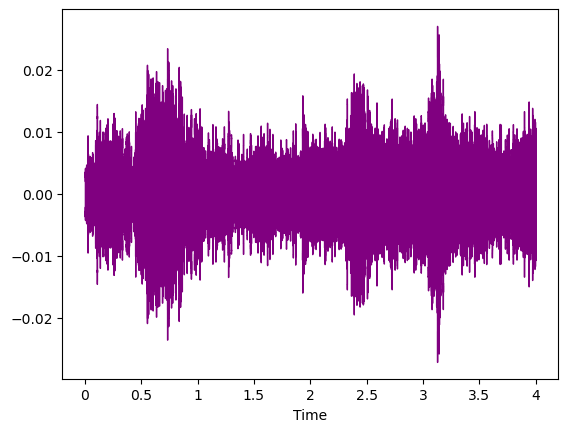

In [30]:
sample_num = 1 #pick a file to display
filename = df.slice_file_name[sample_num] #get the filename

tstart = df.start[sample_num] #define the beginning time of the signal
tend = df.end[sample_num] #define the end time of the signal

#'D:\L_IACD\SoundClassification\UrbanSound8K\audio\fold5\100263-2-0-126.wav'

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)

y, sr = librosa.load(path)
librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple', offset=0.0)

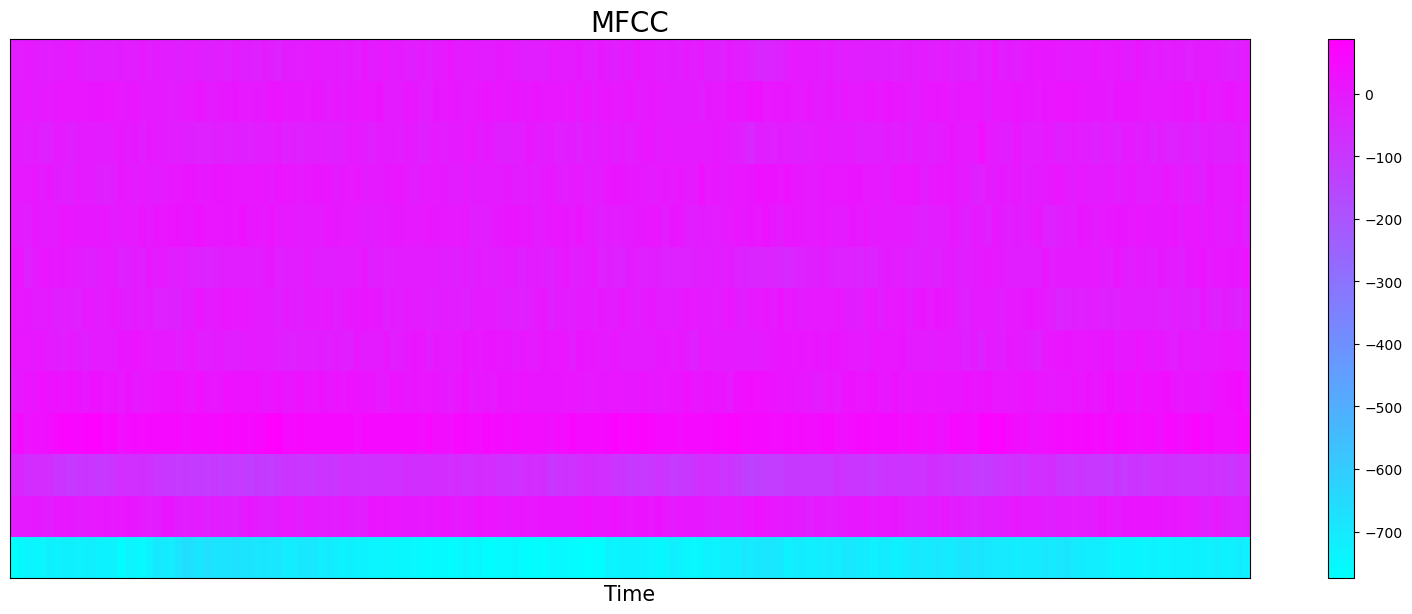

In [31]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 

MFCCs = librosa.feature.mfcc(y = y, n_fft = n_fft, hop_length = hop_length, n_mfcc = 13)
fig, ax = plt.subplots(figsize = (20,7))

librosa.display.specshow(MFCCs, sr=sr, cmap='cool', hop_length = hop_length)
ax.set_xlabel('Time', fontsize = 15)
ax.set_title('MFCC', size = 20)
plt.colorbar()
plt.show()

In [ ]:
def get_features(df_in):
    features = [] #list to save features
    labels = [] #list to save labels
    for index in range(0,len(df_in)):

      #get the filename        
      filename = df_in.iloc[index]['recording_id']+str('.flac') 

      #cut to start of signal     
      tstart = df_in.iloc[index]['t_min'] 

      #cut to end of signal
      tend = df_in.iloc[index]['t_max'] 

      #save labels
      species_id = df_in.iloc[index]['species_id'] 

      #load the file        
      y, sr = librosa.load('train/'+filename,sr=28000)

      #cut the file from tstart to tend 
      y_cut = y[round(tstart*sr,ndigits=None):round(tend*sr, ndigits= None)]

      data = np.array([padding(librosa.feature.mfcc(y_cut, 
         n_fft=n_fft,hop_length=hop_length,n_mfcc=128),1,400)])
      features.append(data)
      labels.append(species_id)
    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)

X,y=get_features(df)